In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from pyCompare import blandAltman

test_path = "../results/hold-out-test.csv"
val_path = "../results/internal-val-data.csv"

external_all_path = "../results/external-data.csv"
prospective_all_path = "../results/prospective-data.csv"

figureSize = (4, 4)
figureDPI = 300


def dice_plot(
    x,
    y,
    title,
    figureSize=figureSize,
    x_label="Reference htTKV (mL)",
    y_label="Dice Similarity Coefficient",
):

    dpi = 300
    fig, ax = plt.subplots(figsize=figureSize, dpi=dpi)
    draw = True
    medianColour = "#6495ED"
    loaColour = "coral"
    pointColour = "#6495ED"

    ax.scatter(x, y, alpha=0.5, c=pointColour)

    median = np.median(y)

    # First quartile (Q1)
    Q1 = np.percentile(y, 25, interpolation = 'midpoint')
    # Third quartile (Q3)
    Q3 = np.percentile(y, 75, interpolation = 'midpoint')

    iqr = Q3 - Q1
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

    print(f"lenth={len(y)} \n{np.sort(y)} \nQ1={Q1:.4f}, Q3={Q3:.4f}")


    offset = 0.03
    ax.text(
        0.97,
        Q1 - 2 * offset,
        f"median {median:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        Q1 - 3 * offset,
        f"IQR (Q1 to Q3)= {iqr:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        Q1 - 4 * offset,
        f"IQR in coral",
        ha="right",
        va="bottom",
        transform=trans,
    )

    ax.axhspan(Q1, Q3, facecolor=loaColour, alpha=0.2)

    # Hide the right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, pad=10)
    ax.set_ylim([0.7, 1.02])
    ax.axhline(np.median(y), color=medianColour, linestyle="--")

    ax.set_yticks(np.arange(0.7, 1.0, 0.05))



In [2]:
def calc_IQR(data):
    # First quartile (Q1)
    Q1 = np.percentile(data, 25, interpolation = 'midpoint')
    # Third quartile (Q3)
    Q3 = np.percentile(data, 75, interpolation = 'midpoint')
    # Interquaritle range (IQR)
    IQR = Q3 - Q1
    
    print(f"IQR, Q1, Q3 = ({IQR:.2f}, {Q1:.2f}, {Q3:.2f})")
    print(f"Median = {np.median(data):.2f}")

    return IQR, Q1, Q3

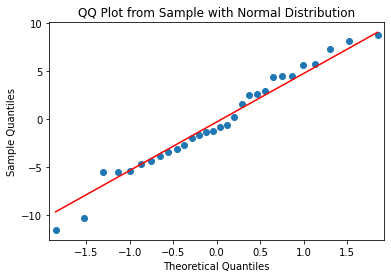

In [3]:
# QQ Plot
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(30)
# q-q plot
qqplot(data, line='s')
plt.title("QQ Plot from Sample with Normal Distribution")
pyplot.show()

In [4]:
import scipy.stats as st

def confidence_int(data):
    return st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 


In [5]:
# external_ds = pd.read_csv(external_path)
# prospective_ds = pd.read_csv(prospective_path)
prospective_ds = pd.read_csv(prospective_all_path)
prospective_ds.TKV_Pred /= 1000  # corrects units to mL
prospective_ds.TKV_GT /= 1000  # corrects units to mL

test_ds = pd.read_csv(test_path)
test_ds.TKV_GT /= 1000  # corrects units to mL
test_ds.TKV_Pred /= 1000  # corrects units to mL


external_ds = pd.read_csv(external_all_path)

val_ds = pd.read_csv(val_path)
val_ds.TKV_GT /= 1000  # corrects units to mL
val_ds.TKV_Pred /= 1000  # corrects units to mL



# Descriptive Stats

In [6]:
prospective_ds.describe()

,Unnamed: 0,TKV_GT,TKV_Pred,patient_dice,Unnamed: 4
count,53.000000,53.000000,53.000000,53.000000,0.0
mean,26.000000,1615.108456,1543.587696,0.959940,NaN
std,15.443445,1584.590428,1471.006391,0.034530,NaN
min,0.000000,248.718000,240.594000,0.798010,NaN
25%,13.000000,553.146000,522.676045,0.936717,NaN
50%,26.000000,972.803718,968.802727,0.970813,NaN
75%,39.000000,2134.357570,2096.764992,0.984251,NaN
max,52.000000,7636.808717,6757.229588,0.996521,NaN


In [7]:
external_ds.describe()

,htTKV,Ax T2,Ax T2.1,Ax T2.2,Ax T2.3,TKV_Pred,TKV_GT,patient_dice
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,978.040000,739.550000,756.030000,779.733000,792.811000,1519.283000,1548.841000,0.971362
std,696.243124,598.703326,595.074159,593.880057,601.794777,1154.748645,1154.025699,0.027502
min,126.900000,102.000000,107.400000,93.560000,99.330000,215.160000,229.530000,0.892602
25%,578.325000,264.475000,266.400000,320.650000,327.550000,891.950000,864.600000,0.965195
50%,759.050000,598.350000,616.300000,654.400000,688.450000,1206.600000,1276.300000,0.977500
75%,1534.275000,968.500000,1011.525000,1020.900000,1030.350000,2066.600000,2232.200000,0.989421
max,2267.200000,1836.000000,1871.000000,2165.000000,2159.000000,4001.000000,4030.000000,0.997888


# Prospective

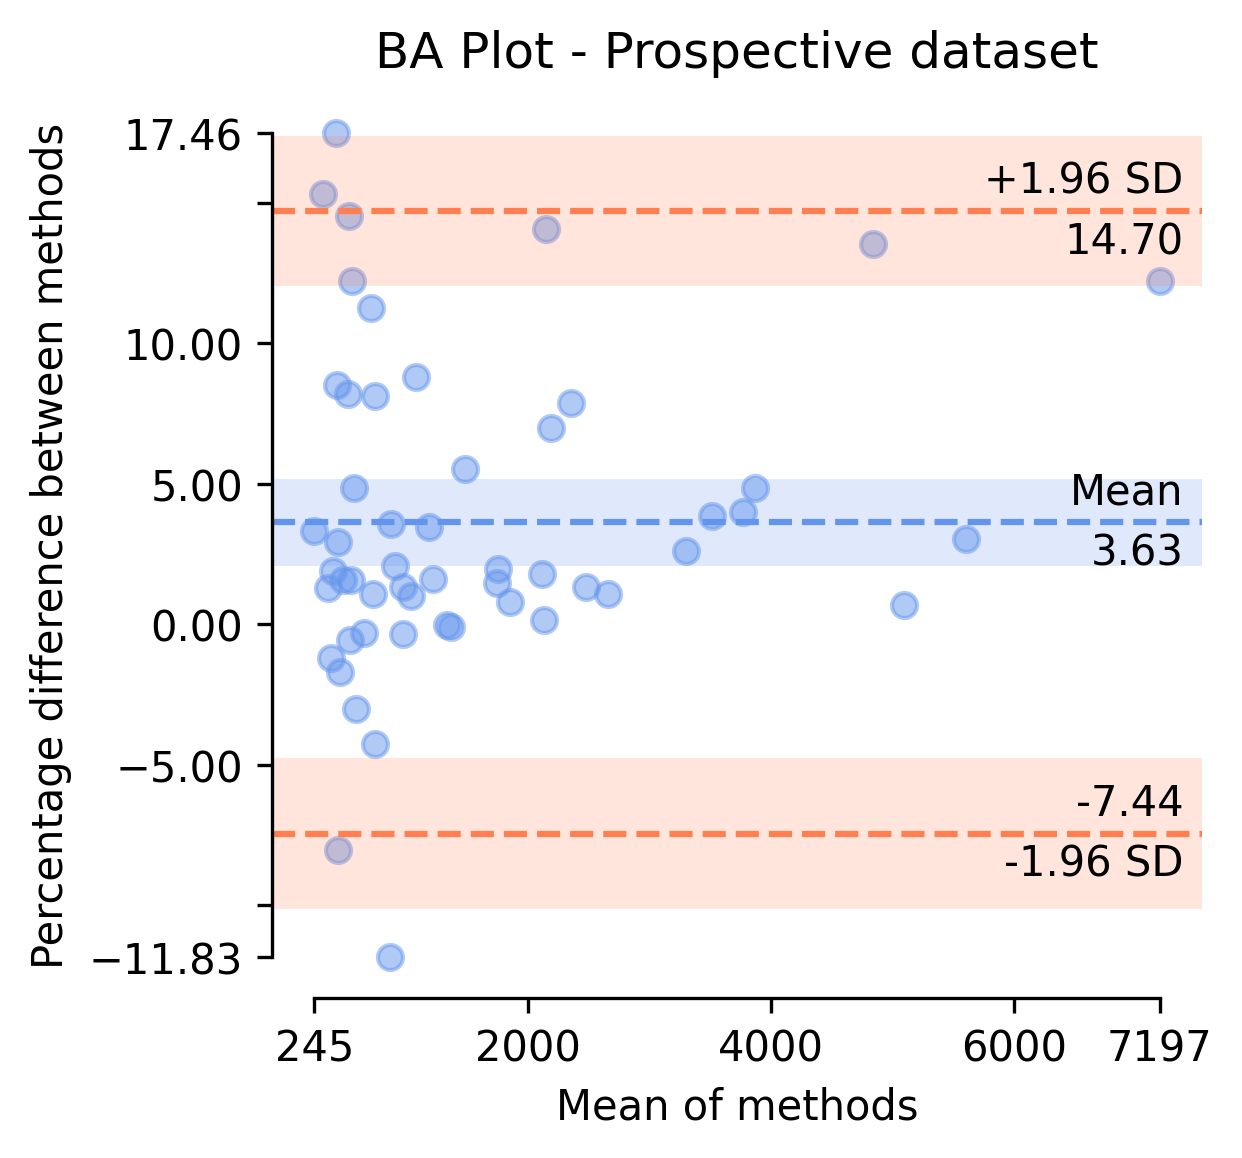

In [8]:

blandAltman(
    prospective_ds.TKV_GT,
    prospective_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Prospective dataset",
    figureSize=figureSize,
    dpi=figureDPI
)

Mean difference (Prospective)= 3.629
SD (Prospective)= 5.650
1.96 * SD (Prospective)= 11.07


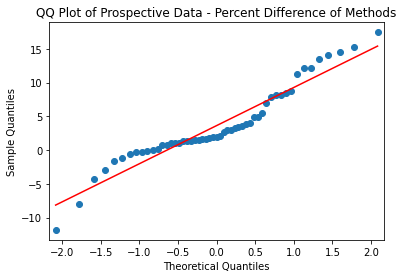

In [9]:
mean = np.mean([prospective_ds.TKV_GT, prospective_ds.TKV_Pred], axis=0)
diff = ((prospective_ds.TKV_GT - prospective_ds.TKV_Pred) / mean) * 100

abs_diff = ((prospective_ds.TKV_GT - prospective_ds.TKV_Pred))

md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (Prospective)= {md:.3f}")
print(f"SD (Prospective)= {sd:.3f}")
print(f"1.96 * SD (Prospective)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot of Prospective Data - Percent Difference of Methods")
pyplot.show()

In [10]:
calc_IQR(diff)

IQR, Q1, Q3 = (6.18, 0.79, 6.97)
Median = 1.98


(6.176276078835489, 0.7914468838494497, 6.967722962684938)

In [11]:
confidence_int(diff)

(2.0570455788989217, 5.2013535763903604)

In [12]:
print(f"Mean abs diff = {np.mean(abs_diff)}")
confidence_int(abs_diff)

Mean abs diff = 71.52075947952832


(28.52027829727932, 114.52124066177733)

# External

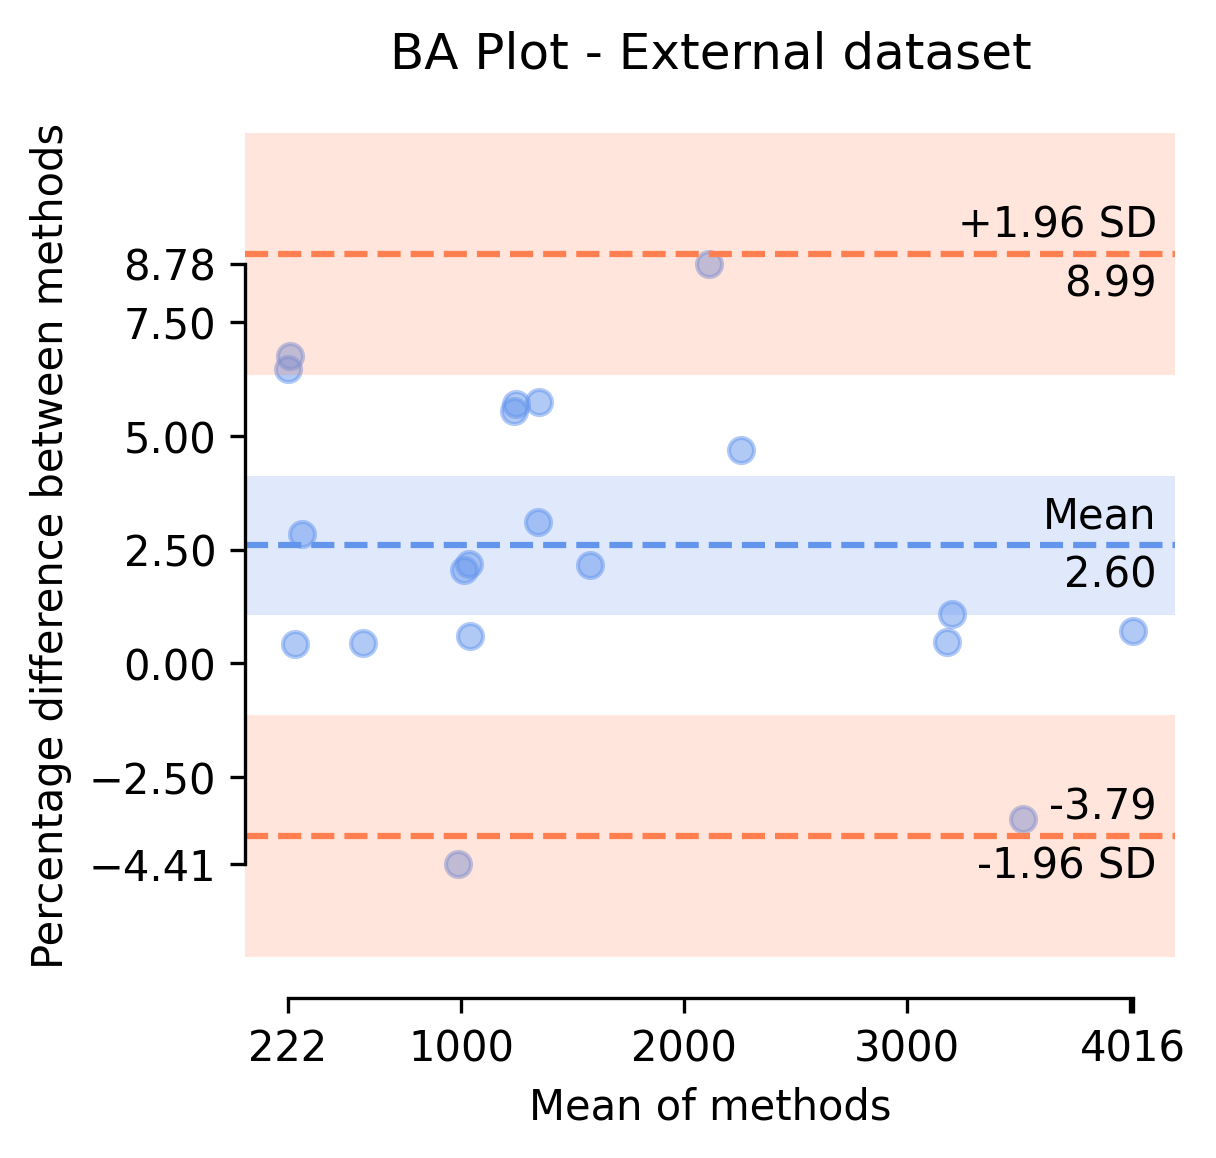

In [13]:
blandAltman(
    external_ds.TKV_GT,
    external_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - External dataset",
    figureSize=figureSize,
    dpi=figureDPI
)

Mean difference (External)= 2.598
SD (External)= 3.260
1.96 * SD (External)= 6.39


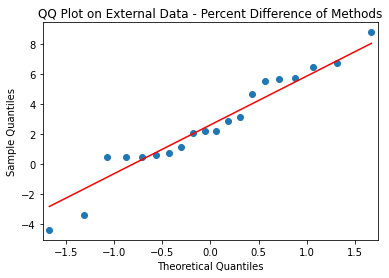

In [14]:
mean = np.mean([external_ds.TKV_GT, external_ds.TKV_Pred], axis=0)
diff = ((external_ds.TKV_GT - external_ds.TKV_Pred) / mean) * 100
abs_diff = ((external_ds.TKV_GT - external_ds.TKV_Pred))

md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (External)= {md:.3f}")
print(f"SD (External)= {sd:.3f}")
print(f"1.96 * SD (External)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on External Data - Percent Difference of Methods")
pyplot.show()

In [15]:
calc_IQR(diff)

IQR, Q1, Q3 = (5.08, 0.54, 5.61)
Median = 2.18


(5.075929515350197, 0.5381587662140377, 5.614088281564234)

In [16]:
confidence_int(diff)

(1.0321184291487318, 4.16307855656116)

In [17]:
print(f"Mean abs diff = {np.mean(abs_diff)}")
confidence_int(abs_diff)

Mean abs diff = 29.558000000000014


(1.7957586940780565, 57.32024130592197)

# Internal Hold-out Test

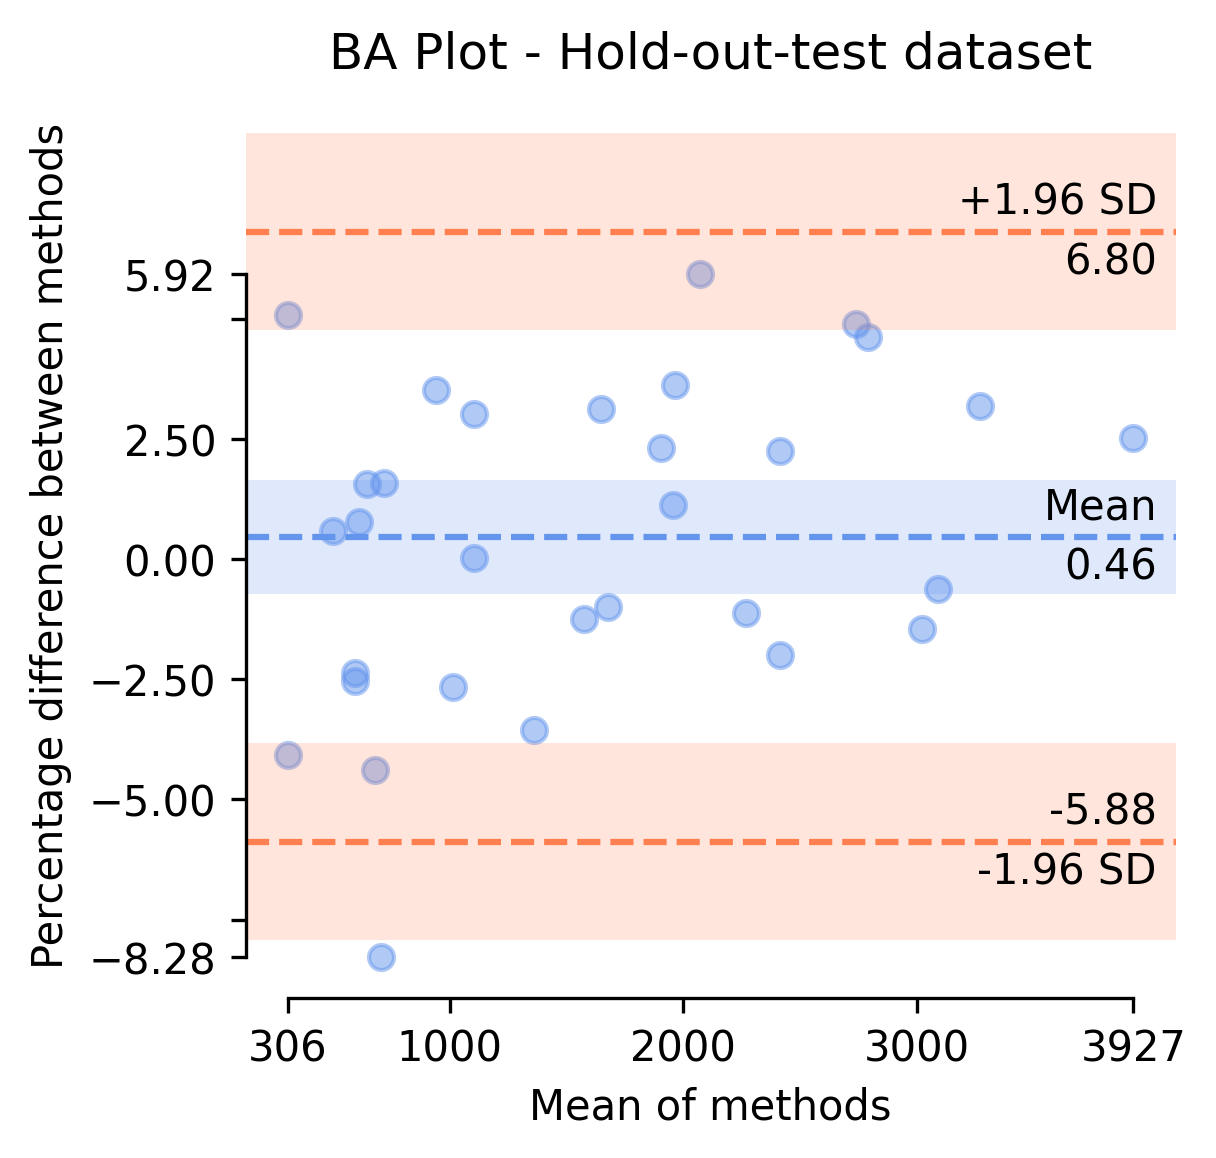

In [18]:
blandAltman(
    test_ds.TKV_GT,
    test_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Hold-out-test dataset",
    figureSize=figureSize,
    dpi=figureDPI
)



Mean difference (Hold-out)= 0.461
SD (Hold-out)= 3.235
1.96 * SD (Hold-out)= 6.34


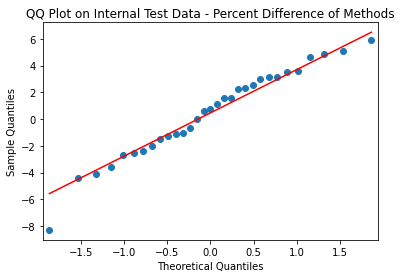

In [19]:
mean = np.mean([test_ds.TKV_GT, test_ds.TKV_Pred], axis=0)
diff = ((test_ds.TKV_GT - test_ds.TKV_Pred) / mean) * 100
abs_diff = ((test_ds.TKV_GT - test_ds.TKV_Pred))

md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (Hold-out)= {md:.3f}")
print(f"SD (Hold-out)= {sd:.3f}")
print(f"1.96 * SD (Hold-out)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on Internal Test Data - Percent Difference of Methods")
pyplot.show()

In [20]:
calc_IQR(diff)

IQR, Q1, Q3 = (4.80, -1.73, 3.07)
Median = 0.77


(4.800138588356711, -1.734910576964183, 3.065228011392528)

In [21]:
confidence_int(diff)

(-0.7455820843924439, 1.6672087446663952)

In [22]:
print(f"Mean abs diff = {np.mean(abs_diff)}")
confidence_int(abs_diff)

Mean abs diff = 18.13834125806451


(-1.9265841987816579, 38.20326671491068)

# Internal Val

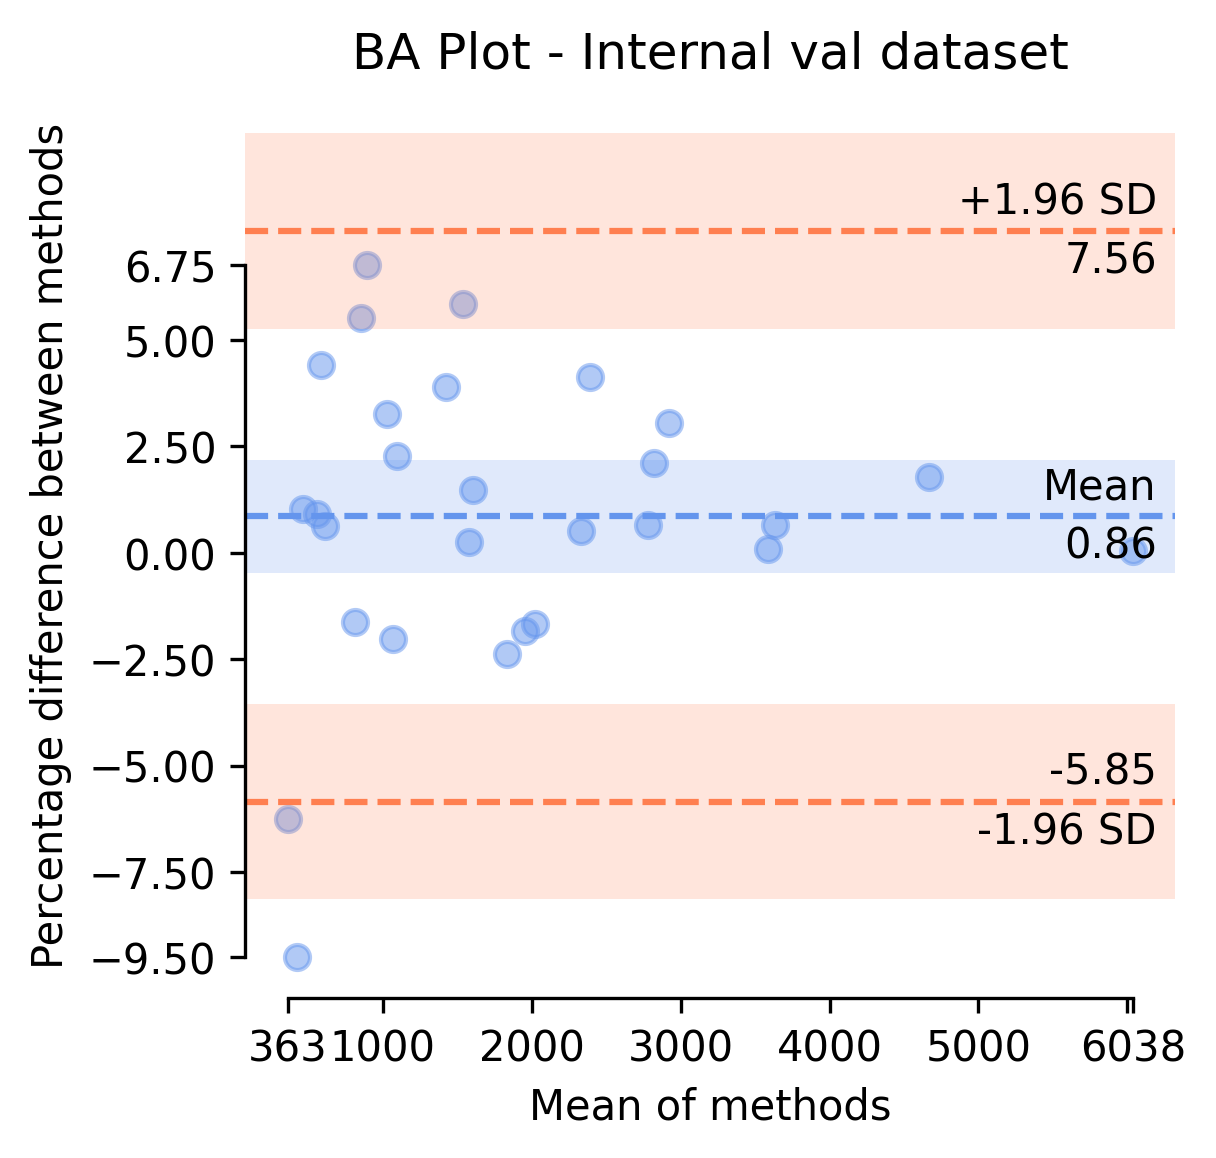

In [23]:
blandAltman(
    val_ds.TKV_GT,
    val_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Internal val dataset",
    figureSize=figureSize,
    dpi=figureDPI
)


Mean difference (Internal Val)= 0.855
SD (Internal Val)=  3.420
1.96 * SD (Internal Val)= 6.70


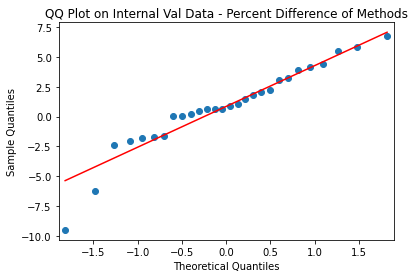

In [24]:
mean = np.mean([val_ds.TKV_GT, val_ds.TKV_Pred], axis=0)
diff = ((val_ds.TKV_GT - val_ds.TKV_Pred) / mean) * 100
abs_diff = ((val_ds.TKV_GT - val_ds.TKV_Pred))

md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (Internal Val)= {md:.3f}")
print(f"SD (Internal Val)=  {sd:.3f}")
print(f"1.96 * SD (Internal Val)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on Internal Val Data - Percent Difference of Methods")
pyplot.show()

In [25]:
calc_IQR(diff)

IQR, Q1, Q3 = (3.94, -0.78, 3.15)
Median = 0.79


(3.9368765293212515, -0.7830718766789224, 3.153804652642329)

In [26]:
confidence_int(diff)

(-0.49548351328945117, 2.205567132770493)

In [27]:
print(f"Mean abs diff = {np.mean(abs_diff)}")
confidence_int(abs_diff)

Mean abs diff = 19.88657915783682


(3.9821435360272, 35.79101477964644)

# Dice Plots

## Prospective


lenth=53 
[0.79800983 0.90494795 0.91011701 0.91889837 0.91931908 0.92143764
 0.9215194  0.92390174 0.92900675 0.9311488  0.93223751 0.93385743
 0.93616875 0.9367174  0.93801304 0.94869632 0.94889126 0.95300649
 0.95347923 0.95947051 0.95998746 0.96049446 0.96450358 0.96732084
 0.96741238 0.96971307 0.97081322 0.97176903 0.97244007 0.97252493
 0.97460467 0.97570051 0.97655521 0.97887356 0.97921155 0.98081061
 0.98147983 0.98249536 0.98408875 0.98425069 0.98553753 0.98637077
 0.98666073 0.98871064 0.99105194 0.99130425 0.99146448 0.99174941
 0.99192493 0.99232368 0.99440742 0.9949051  0.99652141] 
Q1=0.9367, Q3=0.9843


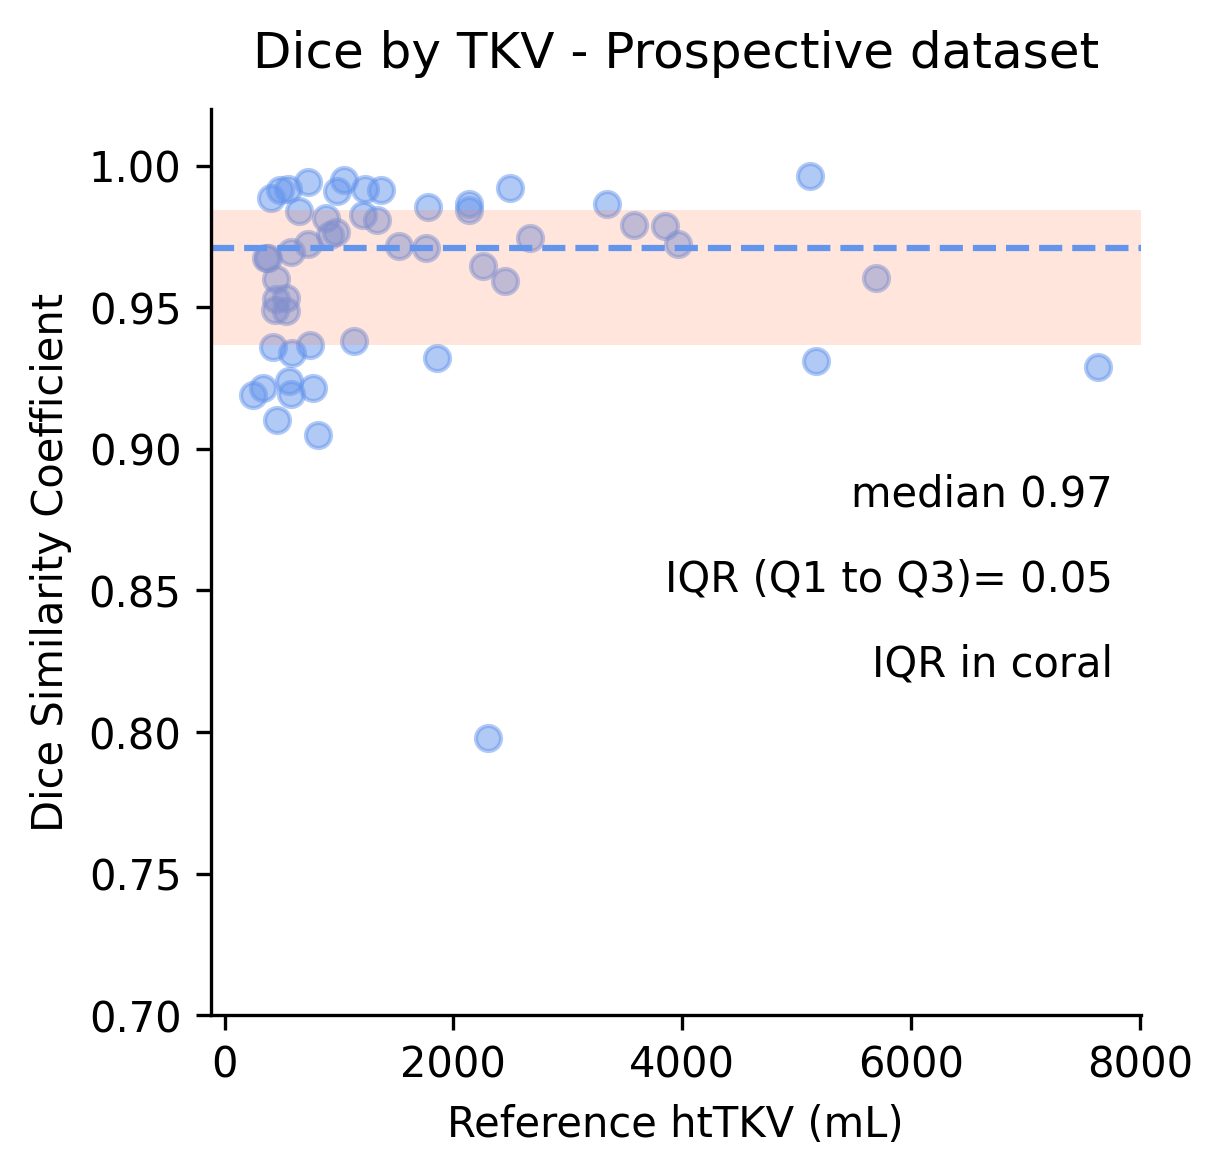

In [28]:
dice_plot(
    prospective_ds.TKV_GT,
    prospective_ds.patient_dice,
    title="Dice by TKV - Prospective dataset",
    figureSize=figureSize,
)

In [29]:
calc_IQR(prospective_ds.patient_dice)


IQR, Q1, Q3 = (0.05, 0.94, 0.98)
Median = 0.97


(0.04753329015797192, 0.936717399101702, 0.984250689259674)

## External

lenth=20 
[0.89260231 0.90881927 0.95366038 0.96186072 0.96412663 0.96555127
 0.96756603 0.96839013 0.9710493  0.97227819 0.98272089 0.9833348
 0.98861437 0.98883498 0.98916972 0.99017556 0.99018741 0.9945441
 0.99585999 0.99788788] 
Q1=0.9648, Q3=0.9897


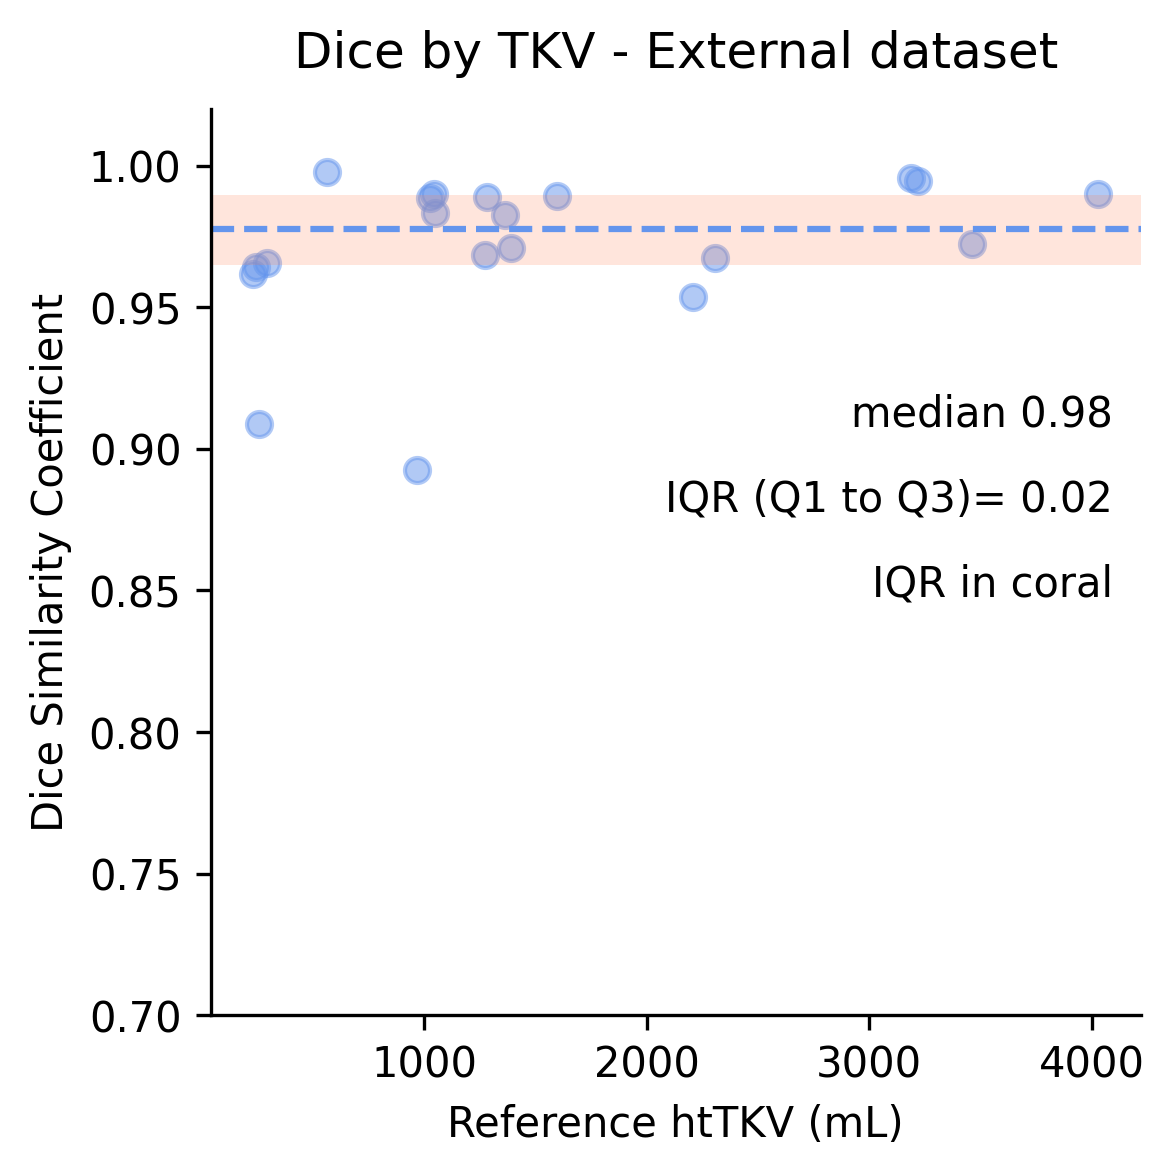

In [30]:
dice_plot(
    external_ds.TKV_GT,
    external_ds.patient_dice,
    title="Dice by TKV - External dataset",
    figureSize=figureSize,
)

In [31]:
calc_IQR(external_ds.patient_dice)

IQR, Q1, Q3 = (0.02, 0.96, 0.99)
Median = 0.98


(0.02483369049999995, 0.9648389470000001, 0.9896726375)

## Hold-Out Test

lenth=31 
[0.82657147 0.87560976 0.91879124 0.93063009 0.93177122 0.9335795
 0.93460387 0.93818039 0.93972212 0.94179243 0.94186872 0.94359148
 0.94426328 0.94482636 0.94640189 0.94658738 0.94692731 0.94930077
 0.9494375  0.95211929 0.95345038 0.9548415  0.95790404 0.95833278
 0.9630397  0.96421957 0.96492755 0.96528    0.96601415 0.96613389
 0.9832921 ] 
Q1=0.9390, Q3=0.9581


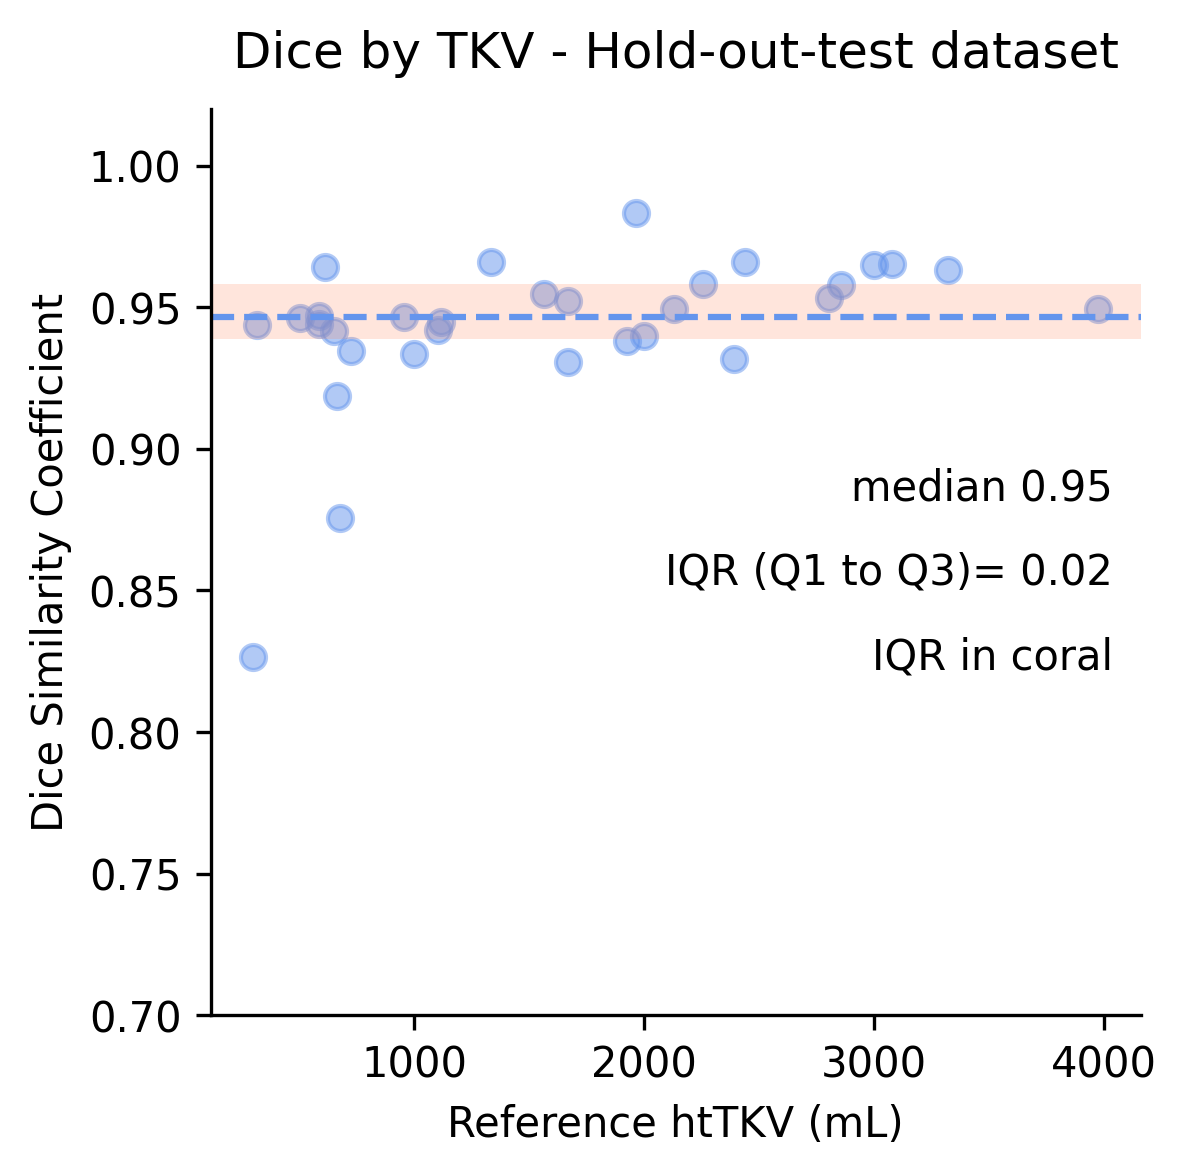

In [32]:
dice_plot(
    test_ds.TKV_GT,
    test_ds.patient_dice,
    title="Dice by TKV - Hold-out-test dataset",
    figureSize=figureSize,
)

In [33]:
calc_IQR(test_ds.patient_dice)

IQR, Q1, Q3 = (0.02, 0.94, 0.96)
Median = 0.95


(0.01916715499999999, 0.938951254, 0.958118409)

## Internal Val

lenth=28 
[0.89370698 0.92839074 0.92984551 0.93112946 0.93285096 0.93437773
 0.93448436 0.93570805 0.93678617 0.93760186 0.94232631 0.94456857
 0.95010048 0.95246571 0.95329368 0.95379746 0.95669061 0.95768982
 0.95959389 0.95968825 0.96000874 0.96185243 0.96454376 0.96518075
 0.96563059 0.96809256 0.97292078 0.97377849] 
Q1=0.9351, Q3=0.9609


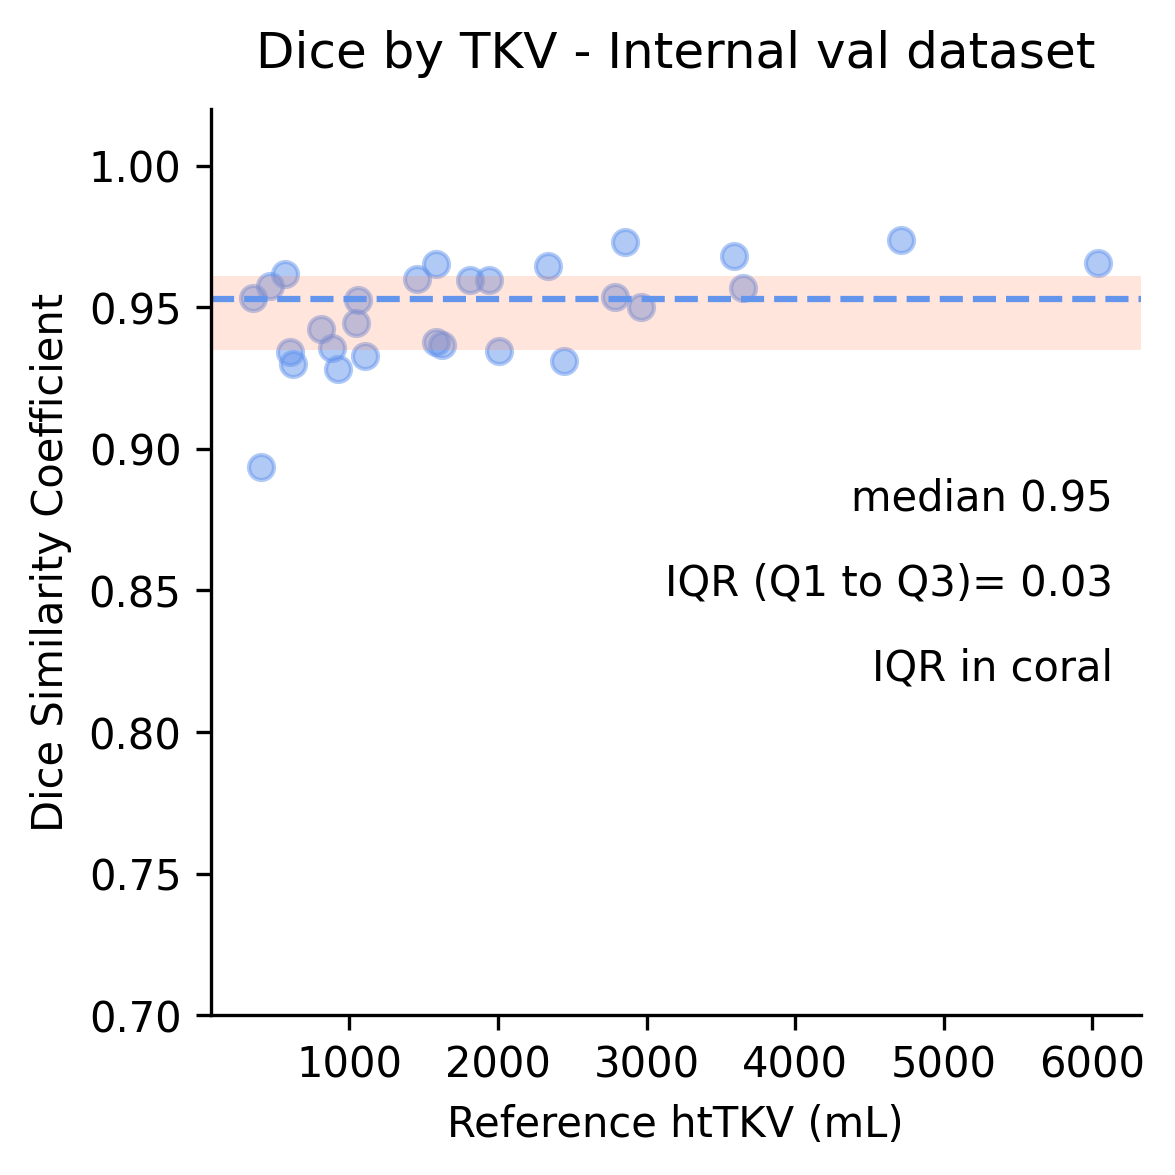

In [34]:
dice_plot(
    val_ds.TKV_GT,
    val_ds.patient_dice,
    title="Dice by TKV - Internal val dataset",
    figureSize=figureSize,
)

In [35]:
calc_IQR(val_ds.patient_dice)

IQR, Q1, Q3 = (0.03, 0.94, 0.96)
Median = 0.95


(0.02583438158035256, 0.9350962042808535, 0.960930585861206)

# Model Assisted vs. Manual

In [36]:
annotation_time_path = "../results/annotation_time_secs.csv"

annotation_time_ds = pd.read_csv(annotation_time_path)

In [37]:
annotation_time_ds.head()

,model_assist,manual
0,1153,2681.0
1,887,1378.0
2,1495,3329.0
3,1879,3928.0
4,523,784.0


## Descriptive Stats

In [38]:
annotation_time_ds.describe()

,model_assist,manual
count,28.000000,28.000000
mean,723.285714,1724.017857
std,433.962608,904.518713
min,29.000000,611.000000
25%,462.500000,1144.500000
50%,555.000000,1462.000000
75%,909.250000,2502.500000
max,1879.000000,3928.000000


## Confidence Intervals

In [39]:
confidence_int(annotation_time_ds.model_assist)

(555.0125818141545, 891.5588467572742)

In [40]:
confidence_int(annotation_time_ds.manual)

(1373.2821153581583, 2074.7535989275557)

## Plot

In [41]:
plt.rcParams['figure.figsize'] = [6.0, 6.0]
plt.rcParams['figure.dpi'] = 300

SMALL_SIZE = 8
MEDIUM_SIZE = 10

plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)

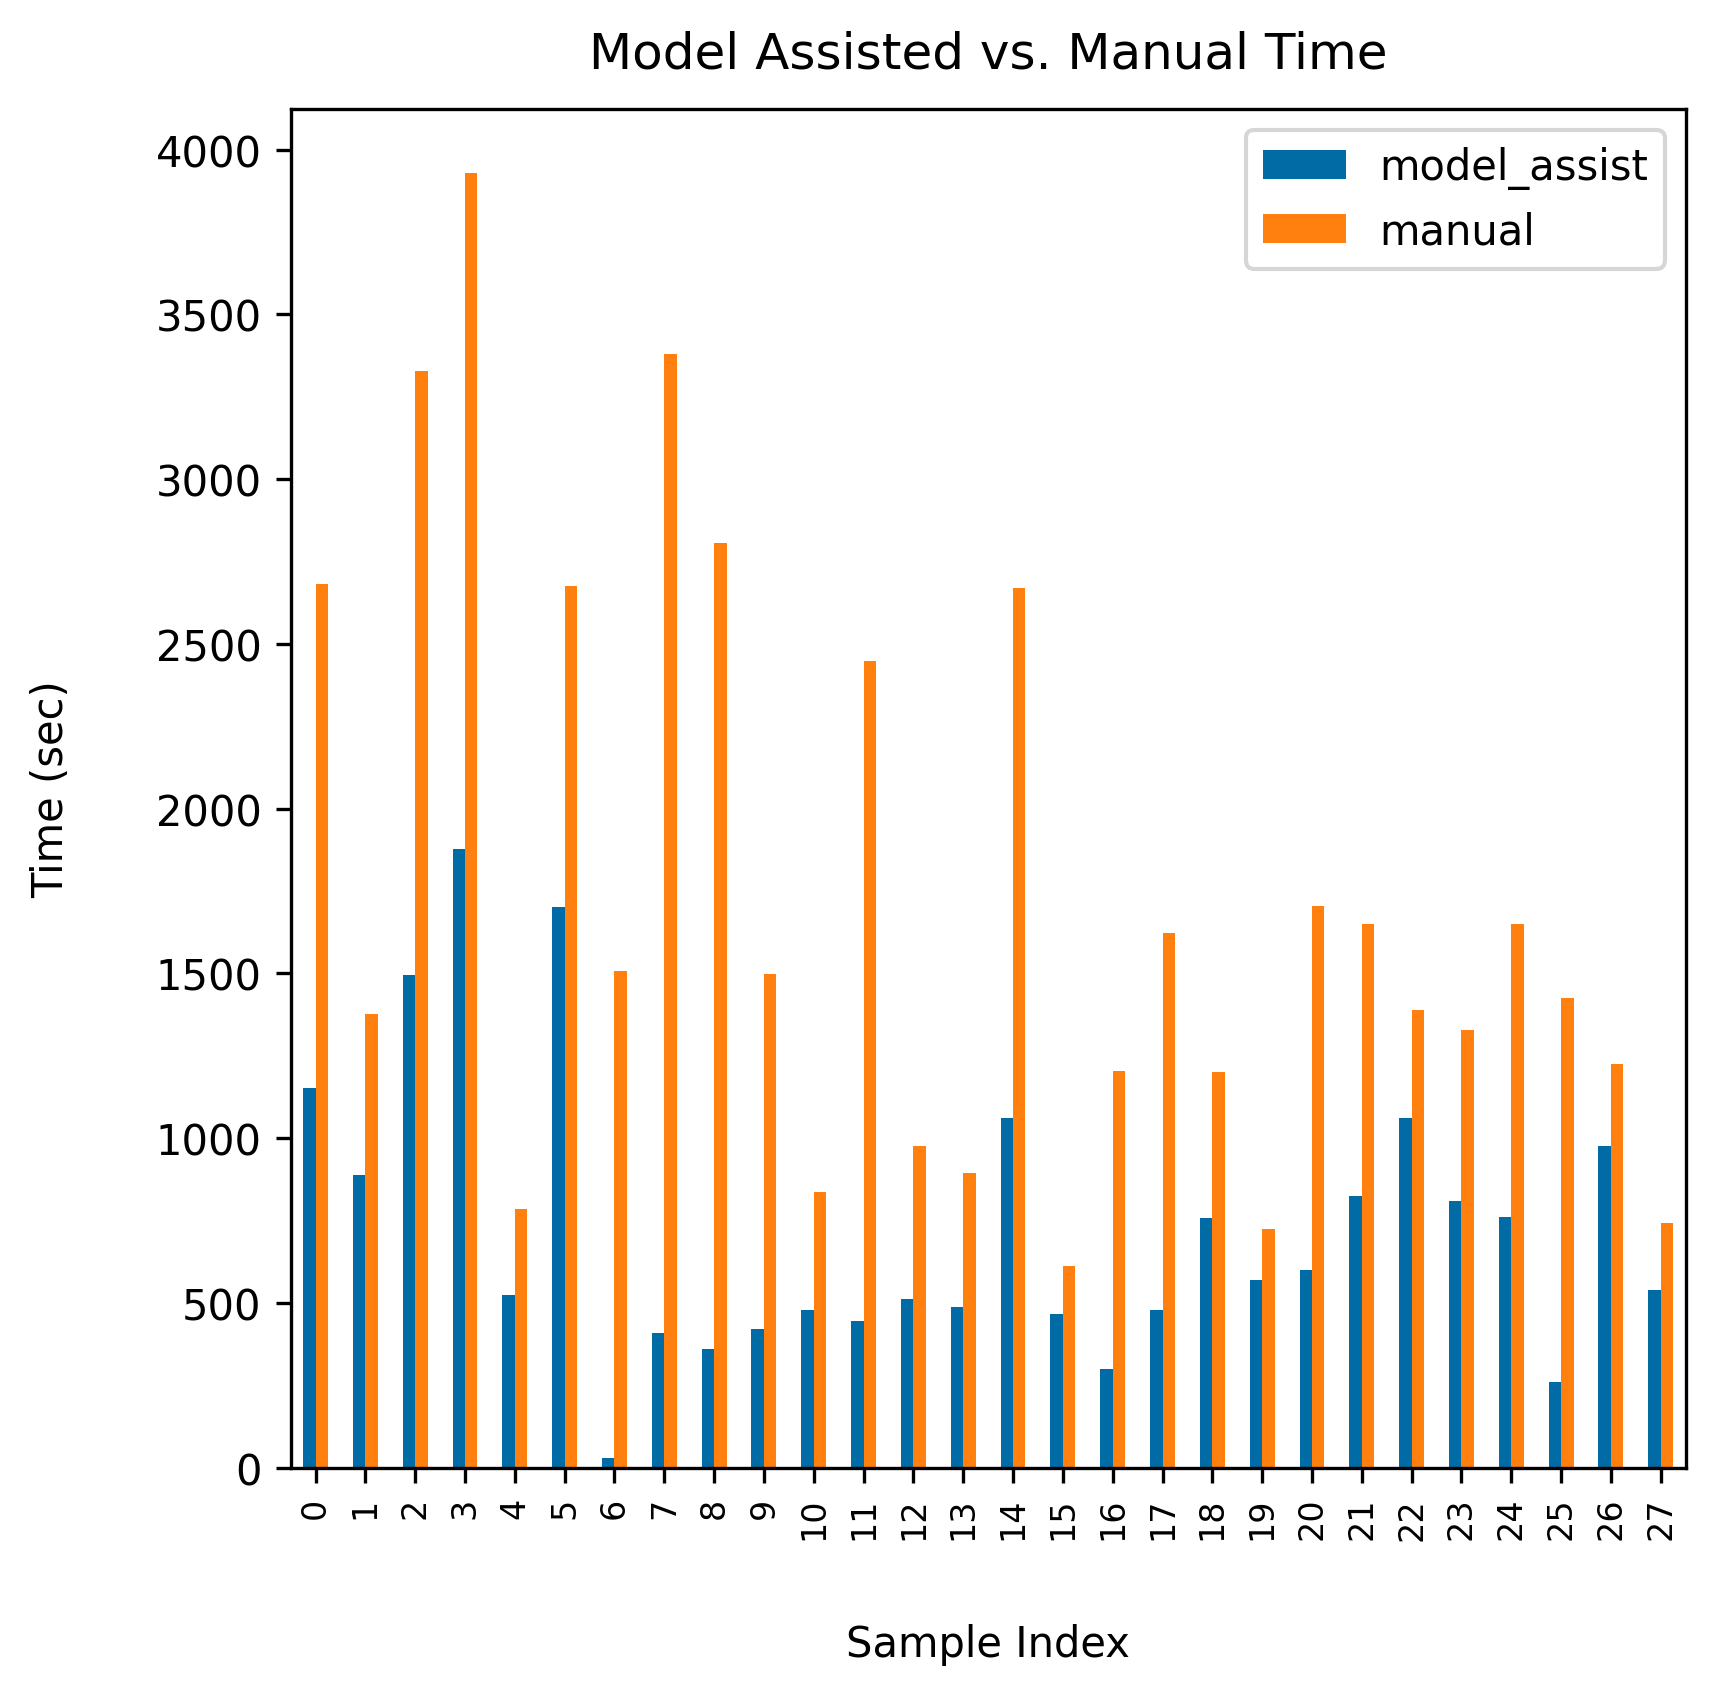

In [42]:
fig, ax = plt.subplots()
plt.style.use('tableau-colorblind10')
plt.xticks(rotation=45)

ax.set_xlabel('Sample Index', labelpad=20)

ax.set_ylabel('Time (sec)', labelpad=20)
ax.set_title("Model Assisted vs. Manual Time", pad=10)
annotation_time_ds.plot(kind='bar', ax=ax)
plt.show()